## ML Problem:
After analysing customer purchase history, we have few heuristic suggest to promote business. But we need something significant. <br>

$Sol^n$: We will build a dynamic recommendation system for people who are shopping so they find relevant product easily & buy more which will boost business. <br>
Then we also need to train such model, test it, deploy it on some server so its is always working. We will also evaluate its impact.


#### PART-3: Basket Analysis
Firstly, we will look at the association b/w different itemsets by doing some basket analysis. <Br>
Then we will then use some ML models to quantify these associations.

We will also prepare different aggregated datasets based on items, customers etc.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
# loading dataset
df = pd.read_parquet('../Data/data_with_Time.parquet')
print("Shape of the dataset:", df.shape)
print("Columns info:", df.info())
df.sample(3)

Shape of the dataset: (1005752, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005752 entries, 0 to 1005751
Data columns (total 16 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Invoice        1005752 non-null  object        
 1   StockCode      1005752 non-null  object        
 2   Description    1005752 non-null  object        
 3   Quantity       1005752 non-null  int64         
 4   InvoiceDate    1005752 non-null  datetime64[ns]
 5   Price          1005752 non-null  float64       
 6   Customer ID    1005752 non-null  int32         
 7   Country        1005752 non-null  object        
 8   Purchase Date  1005752 non-null  datetime64[ns]
 9   Purchase Time  1005752 non-null  datetime64[ns]
 10  Amount         1005752 non-null  float64       
 11  Hour           1005752 non-null  int32         
 12  PartOfDay      1005752 non-null  category      
 13  DayOfWeek      1005752 non-null  category      
 14

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Purchase Date,Purchase Time,Amount,Hour,PartOfDay,DayOfWeek,WeekOfYear,Year
266636,516954,21219,set/4|badges|balloon|girl,2,2010-07-25 15:40:00,1.25,13137,United Kingdom,2010-07-25,1900-01-01 15:40:00,2.5,15,Afternoon,Sunday,29,2010
399556,529958,22467,gumball|coat|rack,6,2010-10-31 15:09:00,2.55,12708,Germany,2010-10-31,1900-01-01 15:09:00,15.3,15,Afternoon,Sunday,43,2010
265249,516877,21677,hearts|stickers,12,2010-07-23 13:30:00,0.85,17364,United Kingdom,2010-07-23,1900-01-01 13:30:00,10.2,13,Afternoon,Friday,29,2010


1. We will also use anonymous transaction for our recommendation model
2. As we dont have any customer data & most of dataset is categorical, we can't use matrix factorisation.
3. We will omit returns from purchase model.


In [3]:
## Removing returned transactions
df = df[df['Quantity']>0].sort_values(['InvoiceDate']) # removing returns

In [4]:
df['StockCode'] = df['StockCode'].astype(str).str.strip()
df['Invoice'] = df['Invoice'].astype(int)
df['Description'] = df['Description'].astype(str).str.strip()

Pricing for transactions is in each countires native country.
So, here we will only deal with United kingdom data as most of the transactions occur there.

There is no way to accurately reach a common pricing level for different countires as they have different Purchasing Power Parity.

In [5]:
df = df[df['Country']=='United Kingdom'] # focusing on UK only
print("Shape of the dataset after filtering UK:", df.shape)

Shape of the dataset after filtering UK: (910890, 16)


### Product wise analysis:


In [6]:
## Most popular products
top_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(5)
print(top_products)

Description
world|war|2|gliders|asstd|designs     97210
white|hanging|heart|t-light|holder    86538
assorted|colour|bird|ornament         74073
jumbo|bag|red|retrospot               70116
brocade|ring|purse                    69965
Name: Quantity, dtype: int64


We will calculate support, confindence and lift.

- $Support(A)$ : how often does product set appear
- $confidence(A-B)$ : how often does B come with A
- $lift(A-B)$ : how likely is someone to buy B after buying A


- Price of items change over time due to which first and last price are different. Prices in retails are dynamic, so we work with most recent price.
OMFG 

In [7]:
## Single product set
item_summary = df.groupby('StockCode').agg(
    Description=('Description', 'first'),  # take first description
    Current_Price=('Price', 'last'), # most recently updated price
    Num_orders=('Invoice', 'nunique'),
    Total_quantity=('Quantity', 'sum'),
    Total_sales=('Amount', 'sum'),
    Num_customers=('Customer ID', 'nunique'),
    Last_sale = ('Purchase Date', 'last')
).reset_index().sort_values(by='Total_quantity', ascending=False)

item_summary['Frequency'] = item_summary['Num_orders'] / item_summary['Num_customers']
item_summary['Quantity per order'] = item_summary['Total_quantity'] / item_summary['Num_orders']
item_summary['Quantity per customer'] = item_summary['Total_quantity'] / item_summary['Num_customers']
item_summary['Sales per customer'] = item_summary['Total_sales'] / item_summary['Num_customers']

display(item_summary.head())


,StockCode,Description,Current_Price,Num_orders,Total_quantity,Total_sales,Num_customers,Last_sale,Frequency,Quantity per order,Quantity per customer,Sales per customer
3529,84077,world|war|2|gliders|asstd|designs,0.63,937,97210,22155.72,454,2011-12-09,2.063877,103.745998,214.118943,48.801145
4257,85099B,jumbo|bag|red|white|spotty,4.13,3702,86729,162545.93,873,2011-12-09,4.240550,23.427607,99.345934,186.192360
4285,85123A,white|hanging|heart|t-light|holder,2.95,5156,86083,236381.91,1440,2011-12-09,3.580556,16.695694,59.779861,164.154104
1423,22197,"popcorn|holder|,|small",0.85,2160,82260,74646.05,554,2011-12-09,3.898917,38.083333,148.483755,134.740162
3977,84879,assorted|colour|bird|ornament,1.69,2643,74073,119860.48,956,2011-12-09,2.764644,28.026107,77.482218,125.377071


In [8]:
from collections import Counter

grouped_data = df.copy()

# Aggregate data per customer
def aggregate_customer(group):
    # Count of unique purchases
    purchase_count = group.groupby('StockCode')['Invoice'].nunique().to_dict()
    
    # Sum of quantities per StockCode
    purchase_quantity = group.groupby('StockCode')['Quantity'].sum().to_dict()
    
    # Last purchase date
    last_purchase_date = group.groupby('StockCode')['Purchase Date'].max().to_dict()
    
    return pd.Series({
        'StockCode': sorted(group['StockCode'].unique()),
        'Purchase count': purchase_count,
        'Purchase quantity': purchase_quantity,
        'Last purchase date': last_purchase_date
    })

customer_history = df.groupby('Customer ID', group_keys=False)
customer_history = customer_history.apply(aggregate_customer, include_groups=False).reset_index()
customer_history.head()

,Customer ID,StockCode,Purchase count,Purchase quantity,Last purchase date
0,-1,"[10002, 10002R, 10080, 10120, 10123C, 10123G, ...","{'10002': 65, '10002R': 3, '10080': 1, '10120'...","{'10002': 192, '10002R': 4, '10080': 12, '1012...","{'10002': 2011-03-15 00:00:00, '10002R': 2010-..."
1,12346,"[15056BL, 15056N, 15056P, 20679, 20682, 20685,...","{'15056BL': 1, '15056N': 1, '15056P': 1, '2067...","{'15056BL': 1, '15056N': 1, '15056P': 1, '2067...","{'15056BL': 2010-03-02 00:00:00, '15056N': 201..."
2,12608,"[10135, 20758, 20768, 20771, 20772, 20774, 207...","{'10135': 1, '20758': 1, '20768': 1, '20771': ...","{'10135': 10, '20758': 4, '20768': 1, '20771':...","{'10135': 2010-10-31 00:00:00, '20758': 2010-1..."
3,12745,"[21215, 21232, 21973, 21974, 21976, 21977, 220...","{'21215': 1, '21232': 1, '21973': 1, '21974': ...","{'21215': 24, '21232': 72, '21973': 12, '21974...","{'21215': 2010-08-10 00:00:00, '21232': 2010-0..."
4,12746,"[20725, 20727, 21528, 21530, 21532, 21534, 215...","{'20725': 1, '20727': 1, '21528': 1, '21530': ...","{'20725': 10, '20727': 10, '21528': 2, '21530'...","{'20725': 2010-06-17 00:00:00, '20727': 2010-0..."


For our model, we will only use the most popular items. So, we remove the product which shows up in less then 2% of total_product/total_transactions.
> Filter = presence > 2% * no of product  < == > proportion of product > 2%

In [9]:
df['StockCode'].value_counts()/df['Invoice'].nunique()

StockCode
85123A    0.143226
85099B    0.102836
22423     0.095142
20725     0.076447
21212     0.075224
            ...   
46776b    0.000028
23692     0.000028
23602     0.000028
23609     0.000028
23617     0.000028
Name: count, Length: 4861, dtype: float64

In [10]:
## For drawing association, we will only use the most popular items
unq_item = len(df['StockCode'].unique())
order_count = len(df['Invoice'].unique())
print("Number of unique items:", unq_item)
print("Number of orders:", order_count)

## proportion for each item
percentage = (df['StockCode'].value_counts()/order_count).sort_values(ascending=False)
items = percentage[percentage > 0.02].index.to_list() # item should be present more then 2% of its part in total dataset
df = df[df['StockCode'].isin(items)]
print("Number of unique items after filtering:", len(df['StockCode'].unique()))
print("Transactions from valid items: ",df.shape)
# df.sample(3)

Number of unique items: 4861
Number of orders: 35999
Number of unique items after filtering: 263
Transactions from valid items:  (307722, 16)


Customer history, itemsets does not need to includes all items(even rare ones) purchased by the customer. <br>
As our model will only use the most popular items. So, baskets, vocabulary will only include the most popular items.

We can skip item data for rare items for faster processing.

Now, we will clear out and prepare our description column.
These description will be used to map cosine similarity for which we will build a vocabulary

In [11]:
import joblib
import pickle

## Feaure engineering for description:
# 1) Clean the text
df['Clean_Description'] = df['Description'].str.lower().str.replace('[^A-Za-z]+', ' ', regex=True).str.strip()

## 2) Build a dictionary of all unique words (fit vectorizer)
from sklearn.feature_extraction.text import CountVectorizer

# FIXED: Use min_df to filter out rare words and reduce vocabulary size
vectorizer = CountVectorizer(ngram_range=(1,2), stop_words='english')
vectorizer.fit(df['Clean_Description'])

# 3) We will create a new column for each word in the dictionary
desc_vocab = vectorizer.transform(df['Clean_Description']).toarray()
desc_vocab = pd.DataFrame(desc_vocab, columns=vectorizer.get_feature_names_out())

print("Vocabulary size:", len(vectorizer.vocabulary_))
print("Shape of the dataset:", desc_vocab.shape)
display(desc_vocab.sample(3))

# 4) Add word frequeny to the dataset
word_freq = desc_vocab.sum(axis=0).sort_values(ascending=False)
desc_vocab.loc['Total_freq'] = word_freq

# 5) Saving the vocabulary
# joblib.dump(vectorizer, '../Models/vectorizer.joblib')
# pickle.dump(vectorizer, '../Models/vectorizer.pkl', 'w')

## 6) Add feature summary column (total number of word occurrences in each description)
df['description_length'] = df['Clean_Description'].apply(lambda x: len(x.split())).fillna(0).astype(int)
df.head(2)

Vocabulary size: 1001
Shape of the dataset: (307722, 1001)


,alarm,alarm clock,alphabet,animals,ant,ant white,antique,antique silver,antique white,apple,...,woolly,woolly hottie,word,world,world war,yellow,yellow design,zinc,zinc light,zinc metal
54909,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
248301,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
306044,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Purchase Date,Purchase Time,Amount,Hour,PartOfDay,DayOfWeek,WeekOfYear,Year,Clean_Description,description_length
0,489434,21232,strawberry|ceramic|trinket|box,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,2009-12-01,1900-01-01 07:45:00,30.0,7,Morning,Tuesday,49,2009,strawberry ceramic trinket box,4
1,489434,21523,fancy|font|home|sweet|home|doormat,10,2009-12-01 07:45:00,5.95,13085,United Kingdom,2009-12-01,1900-01-01 07:45:00,59.5,7,Morning,Tuesday,49,2009,fancy font home sweet home doormat,6


We save vectorizer instead of vocabulary as vectorizer internally builds a mapping of words to their indices. <br>
That mapping - and all tokenization, ngram, stopword, lowercase rules - are stored inside the vectorizer object, not just in the voabulary list.


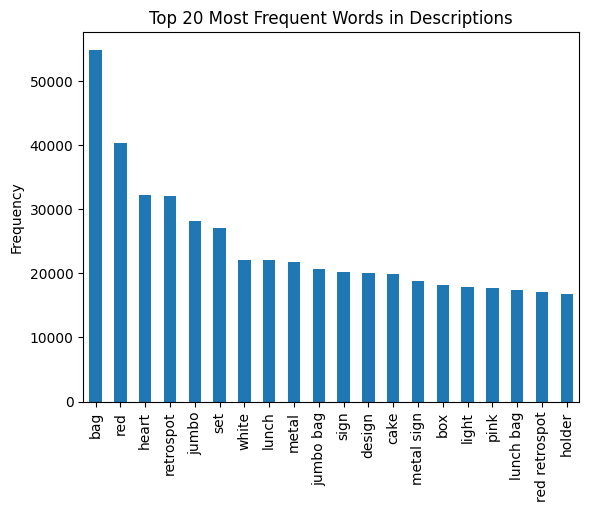

In [12]:
word_freq.head(20).plot(kind='bar')
plt.title("Top 20 Most Frequent Words in Descriptions")
plt.ylabel("Frequency")
plt.show()

In [13]:
## Basket aggregation
baskets = df.groupby(['Invoice', 'InvoiceDate']).agg({
        'Customer ID': 'first',        # same for all rows in the invoice
        'Purchase Date': 'first',
        'Purchase Time': 'first',

        # aggregate product-level details
        'StockCode': lambda x: list(x),
        'Description': lambda x: list(x),
        'Quantity': lambda x: list(x),
        'Price': lambda x: list(x),
        'Amount': lambda x: list(x),
    })

## adding more columns
baskets['Total amount'] = baskets['Amount'].apply(sum)
baskets['Num products'] = baskets['StockCode'].apply(len)

baskets = baskets.reset_index().rename(columns={'index': 'Invoice'})

print("Shape of the baskets dataset:", baskets.shape)
baskets.head(2)


Shape of the baskets dataset: (31812, 12)


,Invoice,InvoiceDate,Customer ID,Purchase Date,Purchase Time,StockCode,Description,Quantity,Price,Amount,Total amount,Num products
0,489434,2009-12-01 07:45:00,13085,2009-12-01,1900-01-01 07:45:00,"[21232, 21523, 21871]","[strawberry|ceramic|trinket|box, fancy|font|ho...","[24, 10, 24]","[1.25, 5.95, 1.25]","[30.0, 59.5, 30.0]",119.5,3
1,489435,2009-12-01 07:46:00,13085,2009-12-01,1900-01-01 07:46:00,[22195],[heart|measuring|spoons|large],[24],[1.65],[39.599999999999994],39.6,1


In [14]:
## some fundamental stats
print("Number of unique customers:", baskets['Customer ID'].nunique())
print("Number of unique products:", df['StockCode'].nunique())

print("Largest basket (by number of products):")
display(baskets.loc[baskets['Num products'].idxmax()])


Number of unique customers: 5101
Number of unique products: 263
Largest basket (by number of products):


Invoice                                                     573585
InvoiceDate                                    2011-10-31 14:41:00
Customer ID                                                     -1
Purchase Date                                  2011-10-31 00:00:00
Purchase Time                                  1900-01-01 14:41:00
StockCode        [23209, 23206, 23203, 23245, 23202, 23199, 232...
Description      [lunch|bag|vintage|doily, lunch|bag|apple|desi...
Quantity         [7, 5, 10, 12, 6, 1, 5, 30, 3, 1, 5, 4, 2, 10,...
Price            [4.13, 4.13, 4.13, 10.79, 4.13, 4.13, 4.13, 3....
Amount           [28.91, 20.65, 41.3, 129.48, 24.78, 4.13, 20.6...
Total amount                                               4086.83
Num products                                                   191
Name: 28958, dtype: object

- Our dataset has 36332 orders in 738 days.


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 307722 entries, 0 to 989560
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Invoice             307722 non-null  int64         
 1   StockCode           307722 non-null  object        
 2   Description         307722 non-null  object        
 3   Quantity            307722 non-null  int64         
 4   InvoiceDate         307722 non-null  datetime64[ns]
 5   Price               307722 non-null  float64       
 6   Customer ID         307722 non-null  int32         
 7   Country             307722 non-null  object        
 8   Purchase Date       307722 non-null  datetime64[ns]
 9   Purchase Time       307722 non-null  datetime64[ns]
 10  Amount              307722 non-null  float64       
 11  Hour                307722 non-null  int32         
 12  PartOfDay           307722 non-null  category      
 13  DayOfWeek           307722 non-nul

In [16]:
# # Saving all progress -> csv can't maintain data types
# baskets.to_pickle('../Data/baskets.pkl')
# customer_history.to_pickle('../Data/customer_history.pkl')
# item_summary.to_pickle('../Data/Item_summary.pkl')
# df.to_parquet('../Data/data_with_features.parquet', index=False)

#### Now we will apply our ML Algorithm to draw associations.


First, we will create a binary matrix for each item in each basket. Then, <br>
We find all itemsets and their associated rules from apiori algorithm which cross support threshold. <br>
Finally, we calculate lift, confidence and support for each rule.


In [17]:
# basket_matrix = df.pivot_table(
#     index='Invoice', columns='StockCode', values='Quantity', aggfunc='sum', fill_value=0
# )
# basket_bool = basket_matrix.map(lambda x: 1 if x > 0 else 0)
# ## Checklist for each item's presence in the basket

# print("Shape of the basket matrix:", basket_bool.shape)
# basket_bool.sample(2)


There are various quantites present in the dataset. Let us take a look at them:

- *Antecedents* – Items that are bought together (the *if* part of the rule).
- *Consequents* – Items that are bought after the antecedents (the *then* part of the rule).
- *Antecedent Support* – Fraction of transactions containing all items in the antecedent:  `P(A)`
- *Consequent Support* – Fraction of transactions containing all items in the consequent:  `P(B)`  
  
- *Support* – Fraction of transactions containing both antecedent and consequent:  `P(A ∩ B)`  

- *Confidence* - likelihood of seeing consequent when antecedent are present = support / antecedent support:
  `conf(A → B) = P(A ∩ B) / P(A)`  

- *Lift* – How much more often the antecedent and consequent occur together than expected if they were independent:
  i.e., proportion of prob with dependence w.r.t. to complete independence
  `lift(A → B) = conf(A → B) / P(B) = P(A ∩ B) / (P(A) × P(B))`  

- *Representativity* – A measure of how well a rule represents the dataset, taking into account both coverage and confidence:  
  `representativity(A → B) = (2 × support) / (P(A) + P(B)) = (2 × P(A ∩ B)) / (P(A) + P(B)) == Harmonic mean(P(A),P(B))`  

- *Leverage* - Difference b/w observed and expected joint probability (0 = independence, + = rule occurs more often than expected)
  `leverage(A → B) = conf(A → B) - P(A)*P(B) = P(A ∩ B) - (P(A) × P(B))`  

- *Conviction* - Ratio of expected error if rule fails under independence to actual error:
  `conviction(A → B) = (1 - P(B)) / (1 - conf(A → B))`  

- *zhangs_metric* - Meansures the strength of association between antecedent and consequent, taking direction and freq into account.
  (-1 perfect -ve, +1 perfect +ve, 0 means independence)
  `zhang(A → B) = (P(A ∩ B) - P(A)*P(B)) / ( max[ P(A ∩ B)*P(¬A), P(A)*P(B)] )`  

- *Jaccard Index* - Measures overlap b/w antecedent and consequent as a fraction of total occurance
  higher value -> most baskets with A or B contains both, lower value -> (A,B) rarely occur together
  `Jaccard(A → B) = P(A ∩ B) / (P(A) + P(B) - P(A ∩ B))`  

- *Certainity* - Measures how much the presence of A increase the prob of B beyond chance
  `Certainity(A → B) = (P(B|A) - P(B)) / (1 - P(B))`  

- *Kulczynski* - Symmetric measure of association - average of confidence in both directions
  i.e., High → A and B co-occur frequently and symmetrically
  `Kulczynski(A,B) = 1/2 * (P(B|A) + P(A|B))`  

  where `P(x|y) = P(x ∩ y)/P(y), P(¬x) = 1-P(x)`  
  


In [18]:
from mlxtend.preprocessing import TransactionEncoder

# Assuming you already have 'baskets' DataFrame with column 'StockCode' as list of items
# Example: baskets['StockCode'][0] -> ['85123A', '71053', '84406B', ...]
transactions = baskets['StockCode'].apply(lambda x: list(set(x))).tolist()

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions, sparse=True)

basket_bool = pd.DataFrame.sparse.from_spmatrix(te_ary, columns=te.columns_)
display("Sample:", basket_bool.head())
print("Memory usage (MB):", basket_bool.memory_usage(deep=True).sum() / 1e6)
print("Basket shape:", basket_bool.shape)


C:\Users\visha\AppData\Local\Temp\ipykernel_27952\1301937210.py:10: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  basket_bool = pd.DataFrame.sparse.from_spmatrix(te_ary, columns=te.columns_)


'Sample:'

,15036,15056BL,15056N,20676,20685,20711,20712,20713,20718,20719,...,84997D,85014B,85049E,85066,85099B,85099C,85099F,85123A,85150,85152
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,True,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Memory usage (MB): 1.538742
Basket shape: (31812, 263)


In [19]:
# from mlxtend.frequent_patterns import association_rules, apriori

# ## must have at least 1% support[1 out of 100 orders must have it] and no more than 3 items
# frequent_itemsets = apriori(basket_bool, min_support=0.01, use_colnames=True, max_len=3)
# frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

# # generating rules -> must have buying probability by 20%
# # rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.1).sort_values('lift', ascending=False)
# rules20 = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.2).sort_values('lift', ascending=False)

# display(frequent_itemsets)
# # display(rules)
# display(rules20)

In [20]:
## Better version then mlxtend
from efficient_apriori import apriori

# Run Apriori directly on list of transactions
itemsets, ruleset = apriori(
    transactions,
    min_support=0.01,        # 1% support threshold
    min_confidence=0.2,      # 20% confidence
    max_length=3,             # up to 3 items
    # use_colnames=True
)

rules_df = pd.DataFrame([{
        'antecedent': tuple(rule.lhs),
        'consequent': tuple(rule.rhs),
        'support': rule.support,
        'confidence': rule.confidence,
        'lift': rule.lift
    } for rule in ruleset
]).sort_values('lift', ascending=False)

print(itemsets)
print("Number of rule entries:", len(rules_df))
print("Number of rules: ",rules_df.shape)
print("Example rules:")
display(rules_df.head())


{1: {('21871',): 722, ('21523',): 1041, ('21232',): 2257, ('22195',): 751, ('22111',): 1608, ('22296',): 802, ('21755',): 1654, ('21754',): 2001, ('82582',): 778, ('21181',): 1740, ('84879',): 2643, ('20971',): 1082, ('84970S',): 1352, ('21912',): 758, ('22112',): 1651, ('20711',): 1004, ('22138',): 1636, ('84029E',): 1097, ('21888',): 739, ('22029',): 916, ('21430',): 725, ('85123A',): 5156, ('21790',): 1785, ('21035',): 849, ('82580',): 1298, ('85150',): 1076, ('20754',): 761, ('84988',): 925, ('21929',): 1515, ('22219',): 1123, ('22178',): 1754, ('21733',): 1667, ('20725',): 2752, ('20726',): 1668, ('21217',): 823, ('22356',): 1405, ('85066',): 887, ('22083',): 1323, ('22114',): 1502, ('22294',): 832, ('20728',): 1897, ('21485',): 1279, ('21928',): 1465, ('20724',): 1754, ('85099B',): 3702, ('22086',): 1952, ('22139',): 1815, ('22273',): 733, ('21731',): 1149, ('21977',): 1796, ('84991',): 1935, ('21212',): 2708, ('82494L',): 1909, ('82486',): 1240, ('21668',): 737, ('82483',): 1105

,antecedent,consequent,support,confidence,lift
1913,"(84997C,)","(84997B, 84997D)",0.010468,0.422053,29.836350
1910,"(84997B, 84997D)","(84997C,)",0.010468,0.740000,29.836350
440,"(21669,)","(21668,)",0.014020,0.605978,26.156554
441,"(21668,)","(21669,)",0.014020,0.605156,26.156554
798,"(22569,)","(22570,)",0.014837,0.625995,25.695669


We shall save itemsets and rules for future use. It is computationally expensive to run apiori everytime and it does not even make a lot of difference to re-check all rules everytime. <br>

We can just use them for periods of time and re-work our association rules every month or week.


In [21]:
## Save rules
# rules_df.to_pickle('../Data/rules.pkl')
# joblib.dump(itemsets, '../Models/itemsets.joblib')

> We dont store anything as csv as csv store all complex datatypes as strings.

#### Manual Implimentation:


In [22]:
# from itertools import combinations
# from collections import defaultdict
# from tqdm import tqdm

# # Step 1️⃣ Count items and pairs
# item_counter = defaultdict(int)
# pair_counter = defaultdict(int)

# for _,basket in tqdm(baskets.iterrows(), total=len(baskets)):
#     unique_items = set(basket['StockCode'])
    
#     # Count individual items
#     for item in unique_items:
#         item_counter[item] += 1
    
#     # Count all size-2 combinations
#     for pair in combinations(sorted(unique_items), 2):
#         pair_counter[pair] += 1

# print("Shape of the item counter:", len(item_counter))
# print(item_counter)
# print("Shape of the pair counter:", len(pair_counter))
# print(pair_counter)


In [23]:
# # Step 2️⃣ Compute Support & Confidence
# num_baskets = len(baskets)
# rules_list = []

# for (a, b), pair_count in tqdm(pair_counter.items()):
#     support = pair_count / num_baskets
#     conf_ab = pair_count / item_counter[a] if item_counter[a] > 0 else 0   # P(b|a)
#     conf_ba = pair_count / item_counter[b] if item_counter[b] > 0 else 0 # P(a|b)
#     lift_ab = conf_ab / (item_counter[b] / num_baskets) if item_counter[b] > 0 else 0
#     lift_ba = conf_ba / (item_counter[a] / num_baskets) if item_counter[a] > 0 else 0
    
#     if (conf_ab  == 0) and (conf_ba == 0): continue # no strong positive association
    
#     # Add both directional rules
#     rules_list.append({'antecedent': a, 'consequent': b, 'support': support, 'confidence': conf_ab, 'lift': lift_ab})
#     rules_list.append({'antecedent': b, 'consequent': a, 'support': support, 'confidence': conf_ba, 'lift': lift_ba})

# rules_list_valid = [r for r in rules_list if 'lift' in r]
# rules_df = pd.DataFrame(rules_list_valid).sort_values('lift', ascending=False)

# ### Automatical minimum support and conf
# # min_support = 0.01
# # min_conf = 0.1
# #  rules_df = rules_df[(rules_df['support'] >= min_support) & (rules_df['confidence'] >= min_conf)]

# print(f"Generated {len(rules_df)} pairwise rules")
# display(rules_df.head(10))